In [2]:
import numpy as np
import torch, os, cv2
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

c:\Users\owner\anaconda3\envs\hyper3d\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
N = 42
R, C = 640, 640
M = R*C
W = 29

In [4]:
A = np.load("A.npy")
b = np.load("I.npy")

In [5]:
# bring camera response function
# 25, 3
cam_crf = np.load(os.path.join("./dataset/image_formation/CRF_cam.npy"))
map_scale = interp1d([cam_crf.min(), cam_crf.max()], [0.,1.])
cam_crf = map_scale(cam_crf).astype(np.float32)
cam_crf = cam_crf.T
print(cam_crf.shape)

(3, 29)


In [6]:
# Make M N 3 W

# A = np.expand_dims(A, axis=2)
# cam_crf = np.expand_dims(np.expand_dims(cam_crf, axis =0), axis=0)
# A = A * cam_crf

In [7]:
A.shape, cam_crf.shape, b.shape

((409600, 126, 29), (3, 29), (51609600, 1))

In [8]:
A_tmp = A.reshape(R,C, N, 3, W)
b_tmp = b.reshape(R,C,N,3)

In [9]:
A_rgb = A_tmp@cam_crf.squeeze().T

In [10]:
A_rgb_sum = A_rgb.sum(axis = 4)

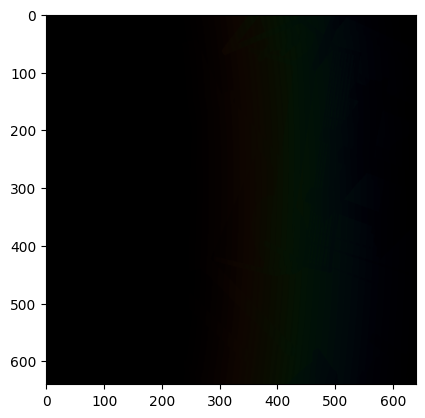

In [13]:
plt.imshow(A_rgb_sum[:,:,-1,:])

In [61]:
A_rgb.shape

(640, 640, 42, 3, 3)

In [22]:
A_tmp.max(), A_tmp.min(), A_tmp.mean()

(0.0062837773, 0.0, 0.0008937332)

In [39]:
b_tmp.max(), b_tmp.min(), b_tmp.mean()

(0.07595488, 0.0, 0.0029349183)

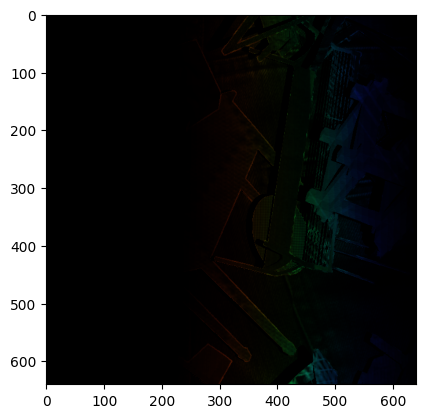

In [41]:
plt.imshow(b_tmp[:,:,-1,]*10)

### Optimize with L1 loss

In [23]:
# Reshape to make M, ...
A = A.reshape(R*C, 1, 3*N, W)
b = b.reshape(R*C, 1, 3*N, 1)    
    
batch_size = 100000
num_iter = 5000
num_batches = int(np.ceil(M / batch_size))
loss_f = torch.nn.L1Loss()
losses = []
X_np_all = torch.zeros(M, 1, W, 1)

# define initial learning rate and decay step
lr = 0.5
decay_step = 800

# training loop over batches
for batch_idx in range(num_batches):
    start_idx = batch_idx * batch_size
    end_idx = min((batch_idx + 1) * batch_size, M)
    batch_size_ = end_idx - start_idx
    A_batch = torch.from_numpy(A[start_idx:end_idx]).to(device)
    B_batch = torch.from_numpy(b[start_idx:end_idx]).to(device)
    X_est = torch.randn(batch_size_, 1, W, 1, requires_grad=True, device=device)
    optimizer = torch.optim.Adam([X_est], lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=decay_step, gamma=0.5)

    optimizer.zero_grad()
    for i in range(num_iter):
        loss = loss_f(A_batch @ X_est, B_batch)
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        if i % 100 == 0:
            print(f"Batch {batch_idx + 1}/{num_batches}, Iteration {i}/{num_iter}, Loss: {loss.item()}, LR: {optimizer.param_groups[0]['lr']}")

    X_np_all[start_idx:end_idx] = X_est.detach().cpu()

X_np_all = X_np_all.numpy()

Batch 1/5, Iteration 0/5000, Loss: 0.006781945005059242, LR: 0.5
Batch 1/5, Iteration 100/5000, Loss: 0.0004548940632957965, LR: 0.5
Batch 1/5, Iteration 200/5000, Loss: 0.0004480137431528419, LR: 0.5
Batch 1/5, Iteration 300/5000, Loss: 0.00045445829164236784, LR: 0.5
Batch 1/5, Iteration 400/5000, Loss: 0.00045784161193296313, LR: 0.5
Batch 1/5, Iteration 500/5000, Loss: 0.00046220485819503665, LR: 0.5
Batch 1/5, Iteration 600/5000, Loss: 0.000464342359919101, LR: 0.5
Batch 1/5, Iteration 700/5000, Loss: 0.00046768959145992994, LR: 0.5
Batch 1/5, Iteration 800/5000, Loss: 0.000469153601443395, LR: 0.25
Batch 1/5, Iteration 900/5000, Loss: 0.00021925369219388813, LR: 0.25
Batch 1/5, Iteration 1000/5000, Loss: 0.00022300658747553825, LR: 0.25
Batch 1/5, Iteration 1100/5000, Loss: 0.00022446736693382263, LR: 0.25
Batch 1/5, Iteration 1200/5000, Loss: 0.00022707438620273024, LR: 0.25
Batch 1/5, Iteration 1300/5000, Loss: 0.00022963348601479083, LR: 0.25
Batch 1/5, Iteration 1400/5000, Lo

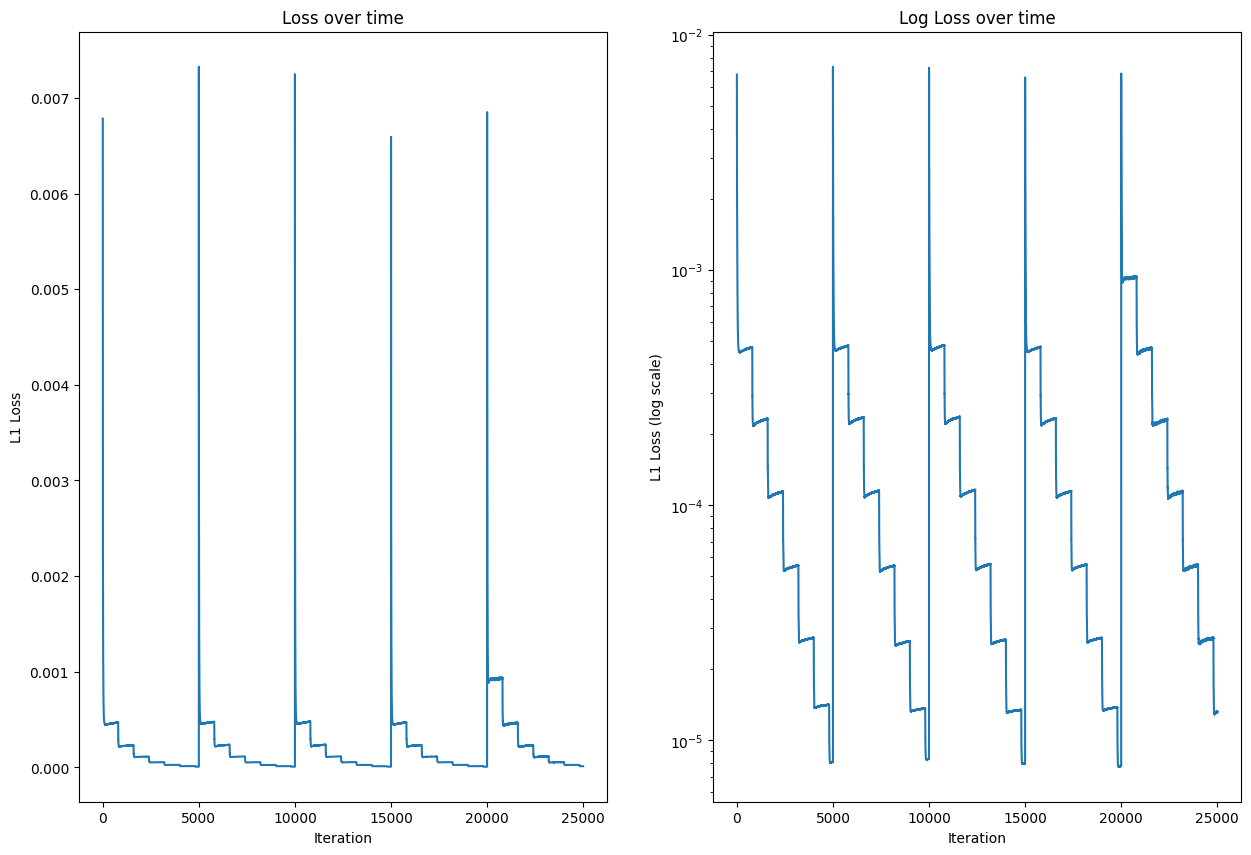

In [25]:
# plot losses over time
plt.figure(figsize=(15,10))

plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title("Loss over time")
plt.xlabel("Iteration")
plt.ylabel("L1 Loss")

plt.subplot(1, 2, 2)
plt.semilogy(losses)
plt.title("Log Loss over time")
plt.xlabel("Iteration")
plt.ylabel("L1 Loss (log scale)")

plt.show()

In [26]:
X_np_all.shape

(409600, 1, 29, 1)

In [28]:
X_np_all = X_np_all.reshape(R, C, W)

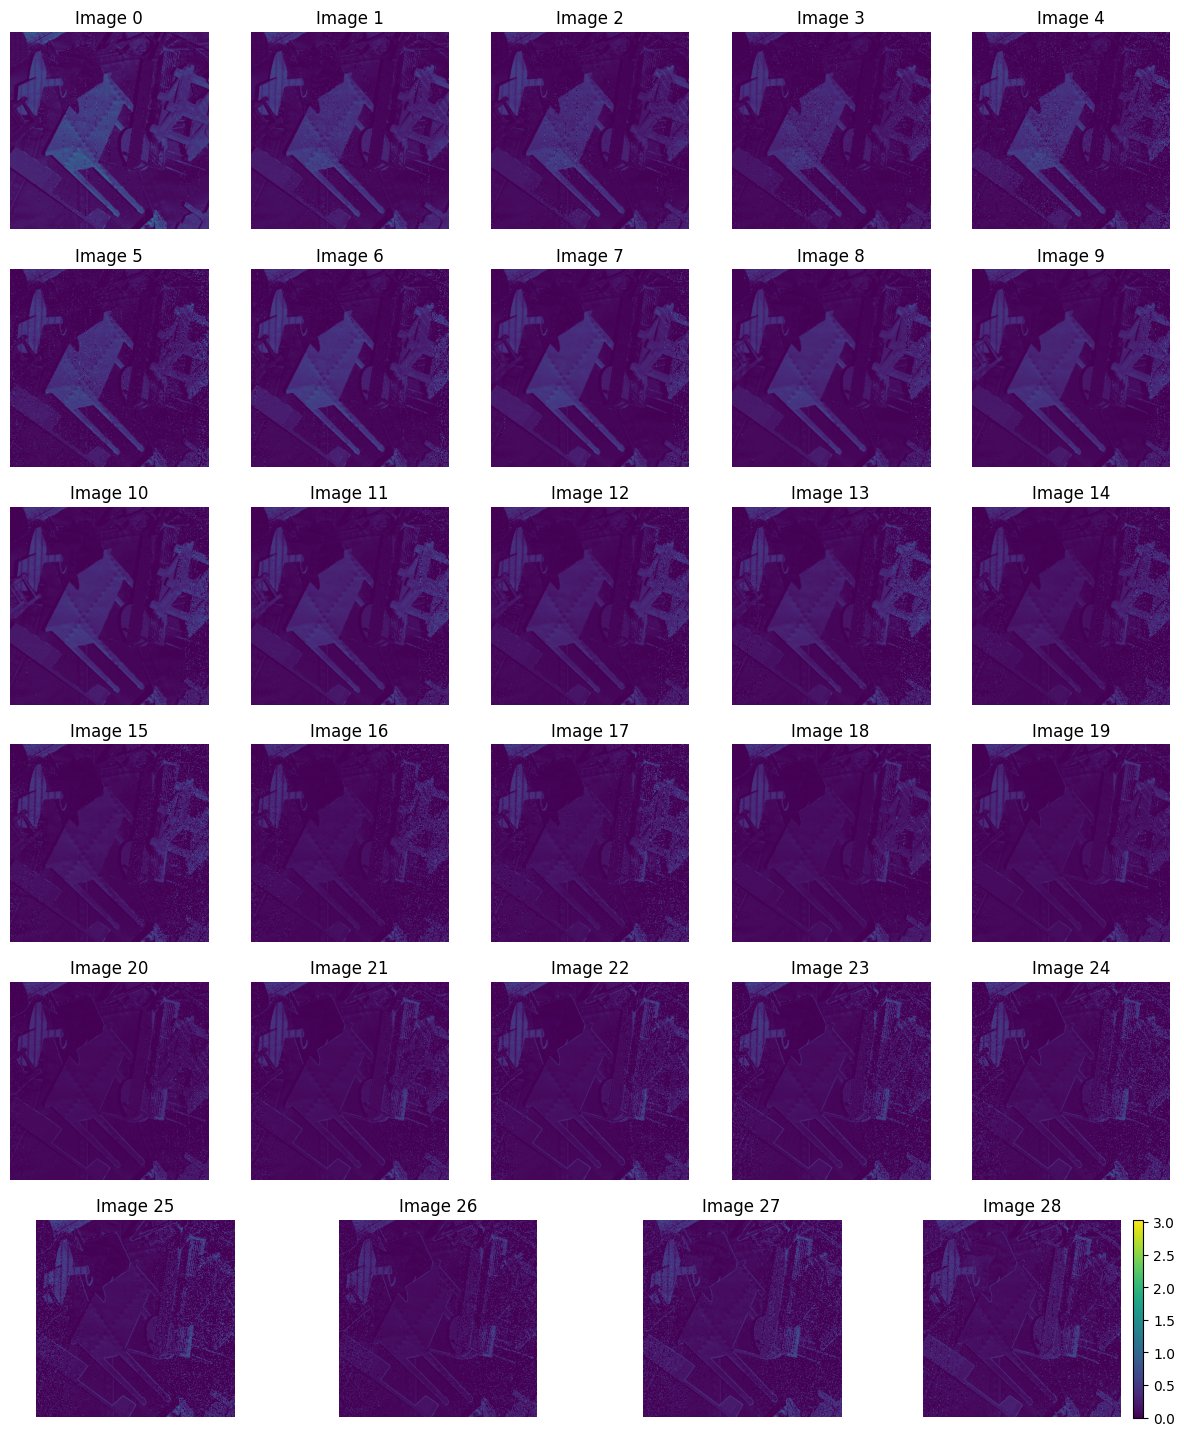

In [29]:
max_images_per_column = 5
num_columns = (W + max_images_per_column - 1) // max_images_per_column
plt.figure(figsize=(15, 3*num_columns))

for c in range(num_columns):
    start_index = c * max_images_per_column
    end_index = min(start_index + max_images_per_column, W)
    num_images = end_index - start_index
    
    for i in range(num_images):
        plt.subplot(num_columns, num_images, i + c * num_images + 1)
        plt.imshow(X_np_all[:, :, i + start_index], vmin=0)
        plt.axis('off')
        plt.title(f"Image {i + start_index}")
        
        if i + start_index == W - 1:
            plt.colorbar()

In [31]:
CRF = cam_crf.reshape(3,W).T

In [32]:
rgb_img = X_np_all@CRF

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


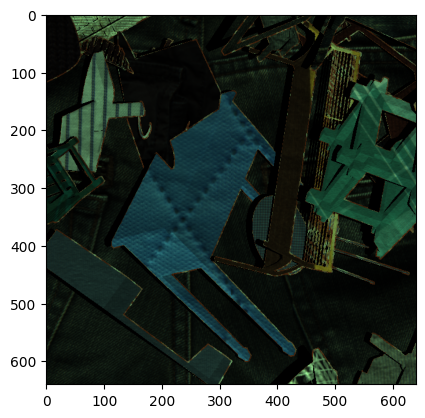

In [33]:
plt.imshow(rgb_img/ rgb_img.max())